In [1]:
import time
import numpy as np
import skvideo.io 
import skimage.io as io
import skimage.transform as trans
import os
from skimage.feature import match_template
import skimage.color
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import pytesseract
import pandas as pd
from PIL import Image
import json
import re

In [2]:
cards_info=pd.DataFrame.from_csv("ClashRoyalBot/Recorder/Data/cards_info.csv")

In [3]:
cardsElixir={}

for _,row in cards_info.iterrows():
    dirinfo=row["images"]
    dirinfo=dirinfo.split(",")
    path=dirinfo[1].split(":")
    fileName=path[1].strip()
    fileName=fileName.replace("'","")
    fileName=fileName.split("/")[1]
    cardsElixir[fileName]=int(row["elixir"])
    
print(cardsElixir)

{'ba94942b0480ceea5aa11ca0264236f53674f71f.jpg': 1, 'ee01b63633318ba2c168829bddf40e7db114774f.jpg': 4, '3fed6ea6a00d8a68aa036dbe6e2f32064665792a.jpg': 3, 'dca411da780d56119b6649aef1746f70fce566d9.jpg': 7, '3827330bcf28a87ef4831fdb031d9549dc419d23.jpg': 4, '965d4d3a3ebab5592fc4e7b0bf8f16f177f64849.jpg': 4, '910b46ebde306457cb56eac5e87cde38a11ace6c.jpg': 6, 'f306280164651a82cb629d8b0c6e290a278d3de3.jpg': 7, '812df463a9b09a0a722e096f5200529851244abe.jpg': 3, '20b1c82f4b5d53ed1bdfad46834d3613e3a48773.jpg': 4, '3f05d4f4de9ad323a0d7e43d4d521dacf8fe90ac.jpg': 5, '32dbdfe40c816b4521385d946903afeedf9d0ce2.jpg': 3, 'c92c17116a9c2901498dfc279efd6b2f749b3642.jpg': 2, 'dc8bb8113d0efe42be35d53c3754460f1397abf6.jpg': 3, 'a2ff6326f3d9162226ca4fec03ef8ec47272788b.jpg': 8, 'beb817b67ffda55dfc43c90b71cb3c0538ec5272.jpg': 7, '66eedb8ec1d3738a8f84bfa617ae6a54b918c656.jpg': 6, '421759f41a9124b8a55293420cb32032c9e4d5be.jpg': 6, '9ded3863198fc7a161b01407996d6ba8bad649b8.jpg': 6, 'e32f9c7d8f4ff5429a91abe33d21d

In [4]:
cardsDir="ClashRoyalBot/Recorder/Data/cards/full/"
cardsList = [ file for file in os.listdir(cardsDir)]
print (len(cardsList))

77


In [5]:
deck=[]
cardNum=0
for card in cardsList:
    cardimg=io.imread(cardsDir+card)
    cardimg=cardimg[14:-14,14:-15,:]
    cardElixir=cardsElixir[card]
    deck.append([cardimg,cardElixir])

In [6]:
grayDeck=[]
for cardInfo in deck:
    card,elixir=cardInfo
    grayDeck.append(cv2.cvtColor(card, cv2.COLOR_RGB2GRAY))

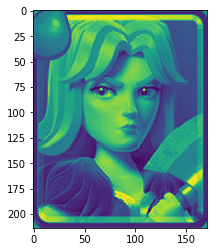

In [7]:
plt.imshow(grayDeck[0])

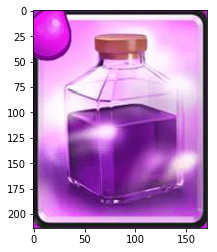

In [8]:
plt.imshow(deck[32][0])

##### Cropping decks to remove borders

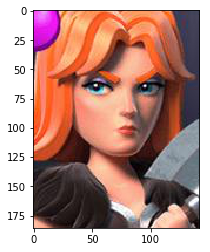

In [9]:
cardtemp=deck[0][0]
cardtemp=cardtemp[14:-14,14:-15,:]
plt.imshow(cardtemp)

(703, 418, 4)


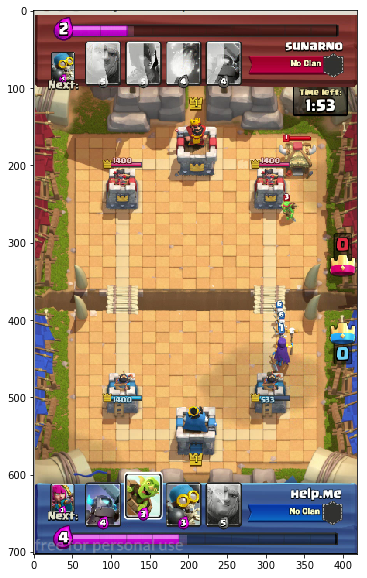

In [40]:
frame = plt.imread("ClashRoyalBot/Recorder/Data/raw/temp_1011.png")
plt.figure(figsize=(10,10))
plt.imshow(frame)
print(frame.shape)

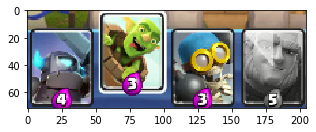

In [61]:
deck_crop = frame[597:669,65:270]
plt.figure(figsize=(5,10))
plt.imshow(deck_crop)

(57, 46, 4)


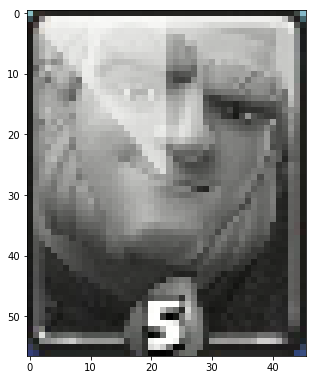

In [12]:
first = deck_crop[12:,:50]
second = deck_crop[12:,53:102]
third = deck_crop[12:,105:153]
fourth = deck_crop[14:-1,158:-1]

plt.figure(figsize=(5,10))
plt.imshow(fourth)
adjustShape=np.shape(fourth)
print(adjustShape)

In [13]:
deck_templates=[]

for cardInfo in deck:
    card,elixir=cardInfo
    card=cv2.resize(card,(adjustShape[1],adjustShape[0]))
    deck_templates.append((card,elixir))

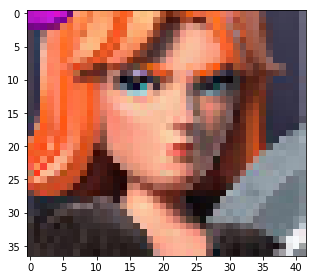

In [14]:
temp=deck_templates[0][0]
temp=temp[10:-10,2:-2,:]

plt.figure(figsize=(5,10))
plt.imshow(temp)

In [62]:
def findCard(frame,template):
    template=template[10:-10,2:-2,:]
    template_gray = cv2.cvtColor(template.astype(np.float32), cv2.COLOR_RGB2GRAY)
    frame_gray = cv2.cvtColor(frame.astype(np.float32), cv2.COLOR_RGB2GRAY)
    res = cv2.matchTemplate(frame_gray,template_gray,cv2.TM_CCOEFF_NORMED)
    threshold = 0.7

    loc = np.where( res >= threshold)
    
    _,found=np.shape(loc)
    
    if found>0:
        return True
    else:
        return False

In [67]:
now_time=time.time()

matches=[]
for cardInfo in deck_templates:
    card,elixir=cardInfo
    matches.append(findCard(deck_crop,card))
        
matches=np.array(matches)

print("Time taken: ",time.time()-now_time)

Time taken:  0.09608173370361328


In [17]:
cardsInDeck=np.zeros((len(deck)))
cardsInDeck[matches]=1
print(cardsInDeck)

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [18]:
for i in range(len(cardsInDeck)):
    print(i," ",cardsInDeck[i])

0   0.0
1   0.0
2   0.0
3   0.0
4   0.0
5   1.0
6   0.0
7   0.0
8   0.0
9   0.0
10   0.0
11   1.0
12   0.0
13   0.0
14   0.0
15   0.0
16   0.0
17   0.0
18   0.0
19   0.0
20   0.0
21   0.0
22   0.0
23   0.0
24   0.0
25   0.0
26   0.0
27   0.0
28   0.0
29   0.0
30   0.0
31   0.0
32   0.0
33   0.0
34   0.0
35   0.0
36   0.0
37   0.0
38   0.0
39   0.0
40   0.0
41   0.0
42   0.0
43   0.0
44   0.0
45   0.0
46   0.0
47   0.0
48   0.0
49   0.0
50   0.0
51   0.0
52   0.0
53   0.0
54   0.0
55   0.0
56   0.0
57   0.0
58   0.0
59   0.0
60   1.0
61   0.0
62   0.0
63   0.0
64   0.0
65   0.0
66   0.0
67   1.0
68   0.0
69   0.0
70   0.0
71   0.0
72   0.0
73   0.0
74   0.0
75   0.0
76   0.0


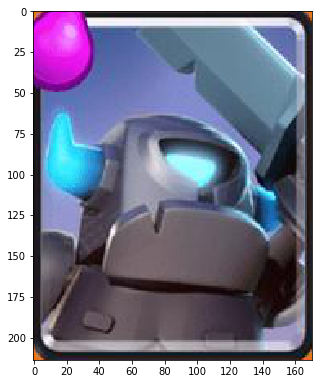

In [19]:
plt.figure(figsize=(5,10))
plt.imshow(deck[67][0])

In [32]:
templates=[]
elixirCards=[]

for cardInfo in deck_templates:
    card,elixir=cardInfo
    templates.append(card)
    elixirCards.append(elixir)
    
print(templates,elixirCards)

[array([[[231, 117,  21],
        [164,  48,  75],
        [165,  13, 188],
        ..., 
        [ 38,  25,  32],
        [ 58,  40,  33],
        [224, 114,  47]],

       [[143,  14,  82],
        [199,  34, 206],
        [236,  22, 254],
        ..., 
        [ 48,  46,  56],
        [ 34,  36,  30],
        [ 86,  32,  22]],

       [[204,  22, 251],
        [243,  24, 254],
        [245,  20, 246],
        ..., 
        [205, 209, 223],
        [ 78,  66,  60],
        [ 24,  32,  55]],

       ..., 
       [[ 47,  41,  58],
        [ 25,  24,  30],
        [242, 231, 231],
        ..., 
        [ 41,  42,  53],
        [ 39,  30,  30],
        [ 21,  27,  41]],

       [[126,  81,  70],
        [ 48,  44,  58],
        [ 28,  26,  31],
        ..., 
        [ 20,  24,  37],
        [ 38,  29,  31],
        [ 47,  28,  21]],

       [[236, 120,  24],
        [114,  56,  35],
        [ 29,  27,  44],
        ..., 
        [ 34,  29,  21],
        [ 51,  15,   3],
        [222, 115

In [33]:
np.save("ClashRoyalBot/Recorder/Data/card_templates.npy",templates)
np.save("ClashRoyalBot/Recorder/Data/card_elixirs.npy",elixirCards)

In [34]:
testtemp=np.load("ClashRoyalBot/Recorder/Data/card_templates.npy")
testtemp2=np.load("ClashRoyalBot/Recorder/Data/card_elixirs.npy")

[4 2 4 3 5 5 1 4 7 4 2 3 5 4 3 3 3 4 5 5 3 6 5 6 5 4 5 4 0 6 2 3 2 4 4 4 3
 3 6 3 6 4 4 3 6 8 3 5 4 5 1 9 2 7 2 2 3 4 3 3 3 7 3 3 5 2 5 4 3 6 4 3 5 6
 7 5 4]


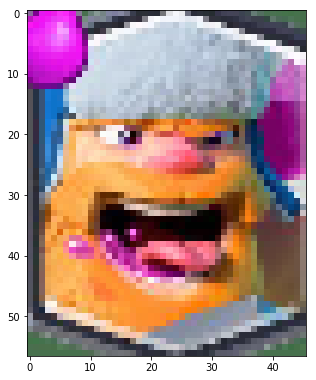

In [37]:
plt.figure(figsize=(5,10))
plt.imshow(testtemp[9])
print(testtemp2)

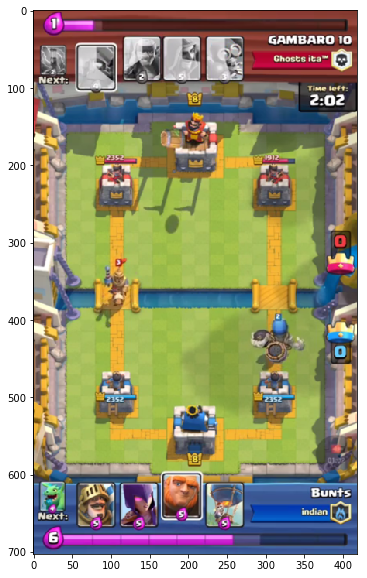

In [49]:
testing = plt.imread("testCardDetect.png")
testing=cv2.resize(testing,(418,703))
plt.figure(figsize=(10,10))
plt.imshow(testing)